In [138]:
import pandas as pd
import talib
import json

# Substitua 'caminho_do_arquivo.csv' pelo caminho do seu arquivo CSV
caminho_do_arquivo = "C:/Projetos/CCM$H1.csv"

# Configurações do mercado futuro
contract_size = 1  # Tamanho do contrato
tick_value = 1   # Valor de cada ponto

# Lê o arquivo CSV
# Lê o arquivo CSV com os nomes das colunas corretos
df = pd.read_csv(caminho_do_arquivo, header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'x'])

# Converte a coluna de data para datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d %H:%M')

# Filtra os anos de 2015 a 2025
df_filtered = df[(df['Date'].dt.year >= 2023) & (df['Date'].dt.year <= 2025)]

# Calcula indicadores
df_filtered['ADX'] = talib.ADX(df_filtered['High'], df_filtered['Low'], df_filtered['Close'], timeperiod=14)
df_filtered['DI+'] = talib.PLUS_DI(df_filtered['High'], df_filtered['Low'], df_filtered['Close'], timeperiod=14)
df_filtered['DI-'] = talib.MINUS_DI(df_filtered['High'], df_filtered['Low'], df_filtered['Close'], timeperiod=14)
df_filtered['TR'] = talib.ATR(df_filtered['High'], df_filtered['Low'], df_filtered['Close'], timeperiod=10)
df_filtered['Operation'] = df_filtered.apply(lambda row: 'Compra' if row['DI+'] > row['DI-'] else 'Venda', axis=1)

# Inicializa variáveis
operations = []
current_operation = None
operation_open = False

# Itera sobre as linhas do DataFrame
for i in range(len(df_filtered)):
    row = df_filtered.iloc[i]
    
    # Se não há operação aberta, verifica se pode abrir uma nova
    if not operation_open and row['ADX'] > 32:
        entry_price = row['Close']
        
        # Calcula Stop e Gain a partir do preço de entrada
        if row['Operation'] == 'Compra':
            stop = entry_price - 2 * row['TR']
            gain = entry_price + 7 * row['TR']
        else:  # Venda
            stop = entry_price + 2 * row['TR']
            gain = entry_price - 7 * row['TR']
        
        # Cria nova operação
        current_operation = {
            "EntryDate": row['Date'].strftime('%Y-%m-%d %H:%M'),
            "Type": row['Operation'],
            "EntryPrice": entry_price,
            "EntryTR": row['TR'],
            "Stop": stop,
            "Gain": gain,
            "ExitDate": None,
            "ExitPrice": None,
            "ExitTR": None,
            "Result": None,
            "Profit/Loss": None
        }
        operation_open = True  # Define que há uma operação aberta
        continue  # Pula para próxima iteração

    # Verifica se há operação aberta para processar
    if operation_open and current_operation:
        if current_operation['Type'] == 'Compra':
            if row['Low'] <= current_operation['Stop']:
                current_operation['Result'] = 'Stop'
                current_operation['ExitPrice'] = current_operation['Stop']
                current_operation['ExitTR'] = row['TR']
                current_operation['Profit/Loss'] = -abs((current_operation['Stop'] - current_operation['EntryPrice']) * contract_size * tick_value)
                current_operation['ExitDate'] = row['Date'].strftime('%Y-%m-%d %H:%M')
                operations.append(current_operation)
                operation_open = False
                current_operation = None
            elif row['High'] >= current_operation['Gain']:
                current_operation['Result'] = 'Gain'
                current_operation['ExitPrice'] = current_operation['Gain']
                current_operation['ExitTR'] = row['TR']
                current_operation['Profit/Loss'] = abs((current_operation['Gain'] - current_operation['EntryPrice']) * contract_size * tick_value)
                current_operation['ExitDate'] = row['Date'].strftime('%Y-%m-%d %H:%M')
                operations.append(current_operation)
                operation_open = False
                current_operation = None
        else:  # Venda
            if row['High'] >= current_operation['Stop']:
                current_operation['Result'] = 'Stop'
                current_operation['ExitPrice'] = current_operation['Stop']
                current_operation['ExitTR'] = row['TR']
                current_operation['Profit/Loss'] = -abs((current_operation['EntryPrice'] - current_operation['Stop']) * contract_size * tick_value)
                current_operation['ExitDate'] = row['Date'].strftime('%Y-%m-%d %H:%M')
                operations.append(current_operation)
                operation_open = False
                current_operation = None
            elif row['Low'] <= current_operation['Gain']:
                current_operation['Result'] = 'Gain'
                current_operation['ExitPrice'] = current_operation['Gain']
                current_operation['ExitTR'] = row['TR']
                current_operation['Profit/Loss'] = abs((current_operation['EntryPrice'] - current_operation['Gain']) * contract_size * tick_value)
                current_operation['ExitDate'] = row['Date'].strftime('%Y-%m-%d %H:%M')
                operations.append(current_operation)
                operation_open = False
                current_operation = None

# Adiciona prints de debug
print("\nDebug Info:")
print(f"Linhas no DataFrame: {len(df_filtered)}")
print(f"Linhas com ADX > 20: {len(df_filtered[df_filtered['ADX'] > 20])}")
print(f"Operações registradas: {len(operations)}")

# Salva os resultados em JSON
with open("operacoes.json", "w") as json_file:
    json.dump(operations, json_file, indent=4, default=str)

C:\Users\Arthur Age\AppData\Local\Temp\ipykernel_11540\1992269547.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['ADX'] = talib.ADX(df_filtered['High'], df_filtered['Low'], df_filtered['Close'], timeperiod=14)
C:\Users\Arthur Age\AppData\Local\Temp\ipykernel_11540\1992269547.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['DI+'] = talib.PLUS_DI(df_filtered['High'], df_filtered['Low'], df_filtered['Close'], timeperiod=14)
C:\Users\Arthur Age\AppData\Local\Temp\ipykernel_115


Debug Info:
Linhas no DataFrame: 4445
Linhas com ADX > 20: 3257
Operações registradas: 81


In [139]:
# Contar a quantidade de operações com "Gain" e "Stop"
gain_count = sum(1 for op in operations if op['Result'] == 'Gain')
loss_count = sum(1 for op in operations if op['Result'] == 'Stop')

# Calcular o lucro ou prejuízo total
total_profit_loss = sum(op['Profit/Loss'] for op in operations)

# Calcular a média de ganhos e perdas
average_gain = sum(op['Profit/Loss'] for op in operations if op['Result'] == 'Gain') / gain_count if gain_count > 0 else 0
average_loss = sum(op['Profit/Loss'] for op in operations if op['Result'] == 'Stop') / loss_count if loss_count > 0 else 0

# Calcular soma total dos gains e losses
total_gains = sum(op['Profit/Loss'] for op in operations if op['Result'] == 'Gain')
total_losses = sum(op['Profit/Loss'] for op in operations if op['Result'] == 'Stop')

# Calcular razão gain/loss
gain_loss_ratio = abs(total_gains / total_losses) if total_losses != 0 else 0

# Criar um dicionário com os resultados
summary = {
    "Total Gains": gain_count,
    "Total Losses": loss_count,
    "Net Profit/Loss": total_profit_loss,
    "Average Gain": average_gain,
    "Average Loss": average_loss,
    "Total Gains Value": total_gains,
    "Total Losses Value": total_losses,
    "Gain/Loss Ratio": gain_loss_ratio
}

# Salvar o resumo em um arquivo JSON
with open("summaryFull.json", "w") as summary_file:
    json.dump(summary, summary_file, indent=4)

# Exibir o resumo no terminal
print(summary)

{'Total Gains': 22, 'Total Losses': 59, 'Net Profit/Loss': 14.2650543833213, 'Average Gain': 3.200271007297218, 'Average Loss': -0.9515408097833474, 'Total Gains Value': 70.40596216053879, 'Total Losses Value': -56.1409077772175, 'Gain/Loss Ratio': 1.254093760648277}


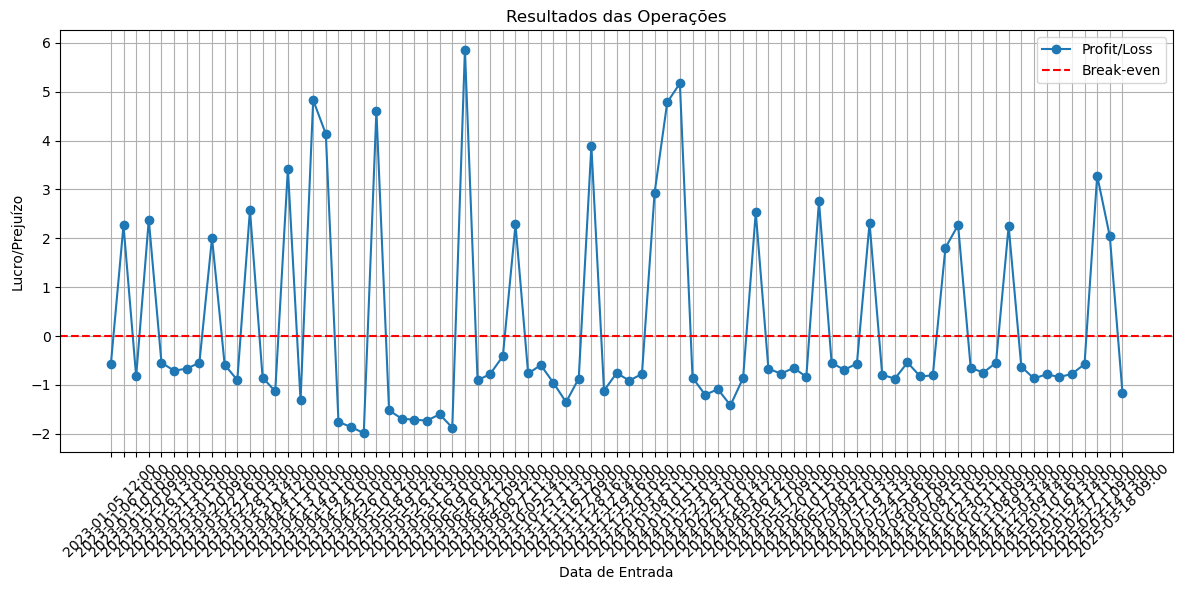

In [140]:
import json

import matplotlib.pyplot as plt

# Ler o arquivo operacoes.json
with open("operacoes.json", "r") as file:
    operations = json.load(file)

# Extrair dados para o gráfico
entry_dates = [op['EntryDate'] for op in operations]
profit_loss = [op['Profit/Loss'] for op in operations]

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(entry_dates, profit_loss, marker='o', label='Profit/Loss')
plt.axhline(0, color='red', linestyle='--', label='Break-even')

# Configurar o gráfico
plt.title('Resultados das Operações')
plt.xlabel('Data de Entrada')
plt.ylabel('Lucro/Prejuízo')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Exibir o gráfico
plt.tight_layout()
plt.show()